<a href="https://colab.research.google.com/github/Maysarah-eltamalawi/Computer-vision-assignment/blob/main/Simulated_Annealing_optimization_algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import random as rd
import math
import openpyxl
from pathlib import Path
no_Dv = 3
ub = np.array ([200,150,100])
lb = np.array ([10,10,10])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
# Load data
driving_cycle = pd.read_excel('/content/drive/MyDrive/driving cycle/ffinal.xlsx')
driving_cycle.drop("Car.SideSlipAngle", inplace=True, axis=1)
driving_cycle.drop("Car.WheelSpd_FL", inplace=True, axis=1)
driving_cycle.drop("Car.WheelSpd_FR", inplace=True, axis=1)
driving_cycle.drop("Car.WheelSpd_RL", inplace=True, axis=1)
driving_cycle.drop("Car.WheelSpd_RR", inplace=True, axis=1)
driving_cycle.drop("Car.YawRate", inplace=True, axis=1)
driving_cycle.drop("Vhcl.Steer.Ang", inplace=True, axis=1)
driving_cycle.head(10)


,Car.ax,Car.ay,Car.v,Time,SOC
0,C1,C1,C1,C1,C1
1,m/s^2,m/s^2,m/s,s,%
2,-0.152787,-0.135081,0.000203,0.001,99.899051
3,-0.042909,-0.013671,0.010553,0.101,99.799202
4,-0.0131,0.022345,0.012579,0.201,99.699453
5,-0.003713,0.027647,0.012644,0.301,99.599803
6,-0.002412,0.009769,0.01284,0.401,99.500253
7,-0.001906,-0.004807,0.013053,0.501,99.400802
8,-0.001871,-0.005577,0.013232,0.601,99.301451
9,-0.001895,0.005298,0.013421,0.701,99.202199


In [ ]:
def obj(curr):
  #putting el DVs fe array
  i = 2
  while i< 2000 :
   Pe=curr[0]
   Pm=curr[1]
   Q0=curr[2]
   totalDistance = 5000
   SOC = (10**-2)*driving_cycle['SOC'][i]
   V= driving_cycle['Car.v'][i]
   G=3
   mf=0
   A=math.sqrt(driving_cycle['Car.ax'][i]**2+driving_cycle['Car.ay'][i]**2)
   time = driving_cycle['Time'][i]
  ####
   OCV=2.85+(4.8*SOC)-(17.8*(SOC)**2)+(38.59*(SOC)**3)+(4.91*(SOC)**4)-(210.52*(SOC)**5)+(433.98*(SOC)**6)-(368.45* (SOC)**7)+(115.81*(SOC)**8)
   FCe=((1-SOC)**2*Q0*3600*OCV)/279673588*0.85*0.85
   DistE= (Q0/FCe)*10**-1

  #####
   Ptotal1= (V/3600*0.85)*(1400*9.81*(0.0076+0.000056*V)+(0.47*3.3*V**2)/21.15)
   Ptotal2= (V/3600*0.85)*(1400*9.81*((0.0076+0.000056*V)*(math.cos(G))+math.sin(G))+(0.47*3.3*V**2)/21.15)
   Ptotal3= (V/3600*0.85)*(1400*9.81*(0.0076+0.000056*V)+(0.47*3.3*V**2)/21.15+1400*0.07*(A/3.6))
   Pinst= max(Ptotal1,Ptotal2,Ptotal3)
   mf= mf + (Pinst*225)/367.1*0.84*9.81
   i=i+1
  # #Evaluating Cost
  Totalmf=mf/time
  TotalCost=(12*Pe+424)+(14*Pm+190)+(8*10*Q0+650)
  UF= DistE/totalDistance
  FC= (Totalmf+FCe)/((10**-5)*0.84*totalDistance)
  Total_objective= FC + TotalCost*10**-4 + (1/UF)
  return Total_objective

In [ ]:
def cool_down_temp(cooling_schedule, curr_temp,beta,alpha):
        schedules = {
            "linear": curr_temp - beta,
            "geometric": curr_temp * alpha,
            "exponential": curr_temp / (1 + beta*curr_temp)
        }
        return schedules.get(cooling_schedule)

In [ ]:
def is_feasible(curr):
  x = curr[0] < ub[0]
  y= curr[1] < ub[1]
  w= curr[0]+curr[1] > 260
  z = x & y & w
  return z

In [ ]:
def init_random_solution():
  x = np.random.rand(no_Dv) * (ub - lb) + lb
  if not(is_feasible(x)):
    x = init_random_solution();
  return x



In [ ]:
def get_new_solution(curr):
  r = np.random.rand(no_Dv)
  new_curr =  curr + r * (ub - curr) + (1 - r) * (lb - curr)
  if not(is_feasible(new_curr)):
    new_curr = get_new_solution(curr)
  return new_curr


In [ ]:
def SA(best, best_eval, max_iter, temp, n_iterPerTemp, min_temp, cooling_schedule, beta, alpha):
  curr, curr_eval = best, best_eval
  best_array=np.array([])
  Iter=np.array([])
  for j in range(max_iter):
    for i in range(n_iterPerTemp):
      # equation for candidate needs to be edited
      candidate = get_new_solution(curr)
      candidate_eval = obj(candidate)
      # check for new best solution


      if candidate_eval <= best_eval:

        # store new best point
        best, best_eval = candidate, candidate_eval
        # report progress
      else:
        # check if we should keep the new point using metropolis acceptance criterion
        diff = candidate_eval - curr_eval
        t = temp / float(i + 1)
        metropolis = math.exp(-diff / t)
        randomp = rd.random()

        if  randomp < metropolis:
          curr, curr_eval = candidate, candidate_eval
      best_array=np.append(best_array,best_eval)
    Iter_array=np.append(Iter,j)
    print('>%d f(%s) = %.5f' % (i, best, best_eval))
    print('>%d f(%s) = %.5f' % (i, curr, curr_eval))
    temp = cool_down_temp(cooling_schedule, temp, beta, alpha)
    if temp <= min_temp :
      break
  return best_array,Iter



In [ ]:
random_sol=init_random_solution()
print(random_sol)
obj(random_sol)

[132.25338109 128.89165859  68.90104881]


6.234906038752327

In [ ]:
random_sol=init_random_solution()
objective_random=obj(random_sol)
best_array,Iterations=SA(random_sol,objective_random,1000,500,5,20,"linear",0.1,0.5)


>4 f([191.98095663 107.10484782  19.46171219]) = 5.85386
>4 f([182.91959691  99.02800216  35.30834264]) = 5.96701
>4 f([157.01327514 140.73564182  10.92116369]) = 5.78605
>4 f([171.39675911 109.56649883  47.37005485]) = 6.07095
>4 f([156.47157857 108.03958665  13.80631269]) = 5.76426
>4 f([185.58404978  78.33431098  47.26923199]) = 6.04339
>4 f([156.47157857 108.03958665  13.80631269]) = 5.76426
>4 f([150.3247717  117.65922376  39.24985313]) = 5.98764
>4 f([156.47157857 108.03958665  13.80631269]) = 5.76426
>4 f([146.59813524 136.40130279  21.41693743]) = 5.85712
>4 f([156.47157857 108.03958665  13.80631269]) = 5.76426
>4 f([194.27426594 149.81318458  27.67773102]) = 5.98657
>4 f([155.18410691 110.57364516  11.28988234]) = 5.74477
>4 f([149.23950743 140.38836847  53.30435336]) = 6.13819
>4 f([155.18410691 110.57364516  11.28988234]) = 5.74477
>4 f([194.78581719 149.01316538  90.64017704]) = 6.52377
>4 f([155.18410691 110.57364516  11.28988234]) = 5.74477
>4 f([157.76532679 104.78781289

In [ ]:
len(best_array)

5000

In [ ]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt

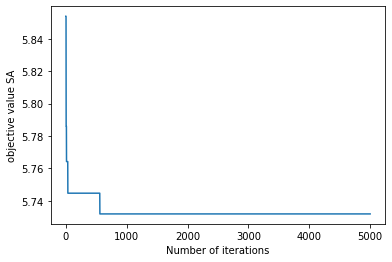

In [ ]:
import matplotlib.pyplot as plt
plt.plot(best_array)
plt.ylabel('objective value SA')
plt.xlabel('Number of iterations')
plt.show()